###Playing with powerlaws

In this notebook I will investigate something discovered while constructing a composite from quasar spectra. 

When constructing the composite I need to normalise the constituent spectra, since intrinsically they have different luminosities and therefore at their fluxes are at different scales. Due to the varying slopes of the constituent spectra I need to chose a wavelenght at which to normalise. I had initially chosen redwards of the $H\alpha$-line, because this is the region in which in intrinsic variability of quasars should be smallest. Thereby the reported standard deviation should mostly reflect the spectrum-to-spectrum variability. 
####Vanden Berk writes: 
*While constructing the median composite, the flux levels of overlapping spectra were scaled so that the integrated flux densities were the same. Thus, we expect the variation in the continuum flux density across the spectrum to reflect the spectrum-to-spectrum differences caused by differing continuum shapes and emission-line fluxes and profiles*

So.. It sound a bit as if, we have different opinions about what best reflects the "true" variability between quasars. I decided to investigate what effect the chosen normalisation region have on my final composite, by using different normalisation regions. I find the following, where the labels in the upper right corner give the region normalised after:

<img src="figs/johan_test.pdf" width=900 height=500>

The different scales are due to the different values of the regions normalised to. If you rescale these spectra (and change the weighted mean with the geometric mean) you get:

<img src="figs/geo_mean.pdf" width=900 height=500>

Clearly there is a change in slope, with composites normalised to the blue region are shallower than composites normalised in the red region. I think, that this is a nummeric consequence of combining powerlaws, so here we are going to reproduce the problem encountered. 

In [1]:
# Setup plotting environment
%matplotlib inline
import matplotlib.pyplot as plt
# use seaborn for nice default plot settings
import seaborn; seaborn.set_style('ticks')

In [2]:
# Importing manupulation packages
import numpy as np
# Reproducible results
np.random.seed(12345)
import scipy.stats as stat


#Faking data
In this section we generate the fake data. We start by randomly drawing N power-law parameters with suitable values for A, $\lambda$, $\alpha$ with a spread consistent with our own data.

$$
y = A   \left(  \frac{\lambda}{\lambda_0}  \right) ^\alpha
$$


From these sets of parameters we generate complete data sets from the power-law and the error in the y value is just 10 percent of the y value. That the error scales with the value will turn out to be important later.

In [229]:
# Generating fake data
def power_law(t, params):
    A, lambda_0, alpha = params
    return A * (t / lambda_0) ** alpha 

def voigt(xarr, params):
    """
    voigt profile
    V(x,sig,gam) = Re(w(z))/(sig*sqrt(2*pi))
    z = (x+i*gam)/(sig*sqrt(2))

    Converted from
    http://mail.scipy.org/pipermail/scipy-user/2011-January/028327.html
    """
    amp,xcen,Gfwhm,Lfwhm = params
    tmp = 1.0/wofz(np.zeros((len(xarr)))+1j*np.sqrt(np.log(2.0))*Lfwhm).real
    tmp = tmp*amp*wofz(2*np.sqrt(np.log(2.0))*(xarr-xcen)/Gfwhm+1j*np.sqrt(np.log(2.0))*Lfwhm).real
    return tmp


def generate_data(params, params_v, N):
    
    t = np.arange(1000, 10000, 5)
    y = np.zeros([N, len(t)])
    yerr = y.copy()
    for n in range(N):
        y[n] = power_law(t, params[n]) + voigt(t, params_v[n]) 
        yerr[n] =  y[n] * 0.1 + 1e4
        y[n] += yerr[n] * np.random.randn(len(t))
    return t, y, yerr

n_sets = 50

mu_A, sigma_A = 1e10, 1e12 # mean and standard deviation
A = np.random.normal(mu_A, sigma_A, n_sets)

mu_lambda_0, sigma_lambda_0 = 5500, 2000 # mean and standard deviation
lambda_0 = np.random.normal(mu_lambda_0, sigma_lambda_0, n_sets)

mu_alpha, sigma_alpha = -1.5, 0.5 # mean and standard deviation
alpha = np.random.normal(mu_alpha, sigma_alpha, n_sets)

parameters = np.array([A, lambda_0, alpha]).transpose()



mu_amp, sigma_amp = 1, 0.3 # mean and standard deviation
amp = np.random.normal(mu_amp, sigma_amp, n_sets)

mu_xcen, sigma_xcen = 7000, 10 # mean and standard deviation
xcen= np.random.normal(mu_xcen, sigma_xcen, n_sets)

mu_Gfwhm, sigma_Gfwhm = 50, 10 # mean and standard deviation
Gfwhm = np.random.normal(mu_Gfwhm, sigma_Gfwhm, n_sets)

mu_Lfwhm, sigma_Lfwhm = 1, 0.5 # mean and standard deviation
Lfwhm = np.random.normal(mu_Lfwhm, sigma_Lfwhm, n_sets)

parameters_v = np.array([amp * A ,xcen,Gfwhm,Lfwhm]).transpose()




t, y, yerr = generate_data(parameters, parameters_v, n_sets)

We plot the fake data.

[]

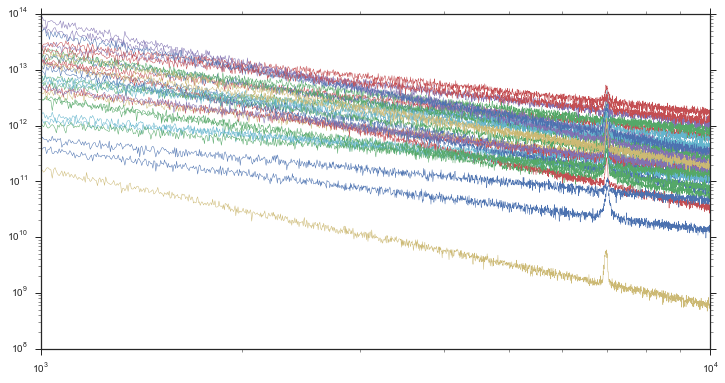

In [230]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)
for n in range(n_sets):
    ax.plot(t, y[n], lw=0.5)
plt.semilogx()
plt.semilogy()   

We then normalise at three different localtion and generate the mean spectra.

[]

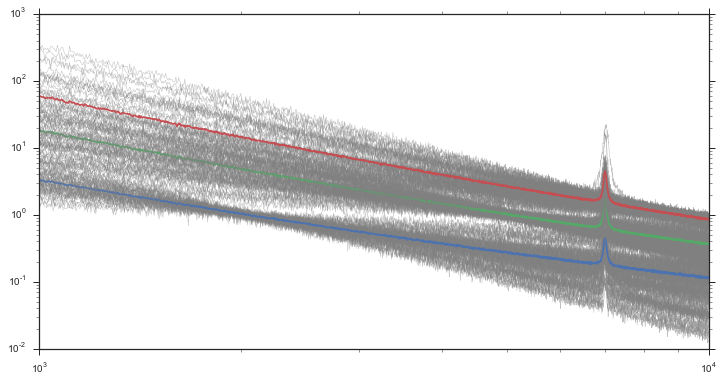

In [231]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
    
    mean = np.average(y, axis = 0)
    ax.plot(t, mean)
    
plt.semilogx()
plt.semilogy()

If we then scale the three composites to compare, we see a clear effect.

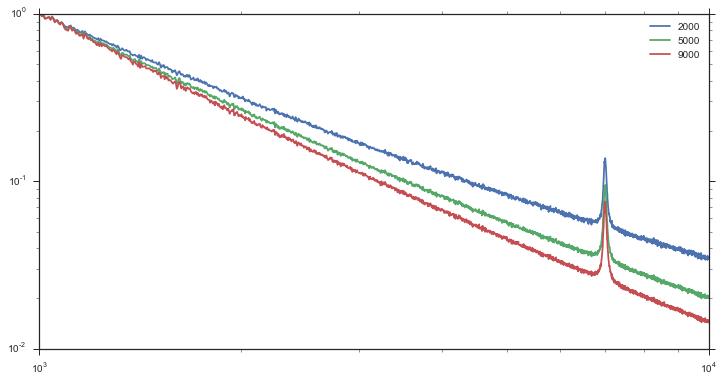

In [238]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = np.average(y, axis = 0)
    ax.plot(t, mean / np.max(mean), label = str(k))
    
plt.semilogx()
plt.semilogy()
plt.legend()
#plt.xlim((6000,8000))
plt.savefig('figs/mean_test.pdf')

Whereas if we instead calculate the geometric mean, the relative differences disappear.

[]

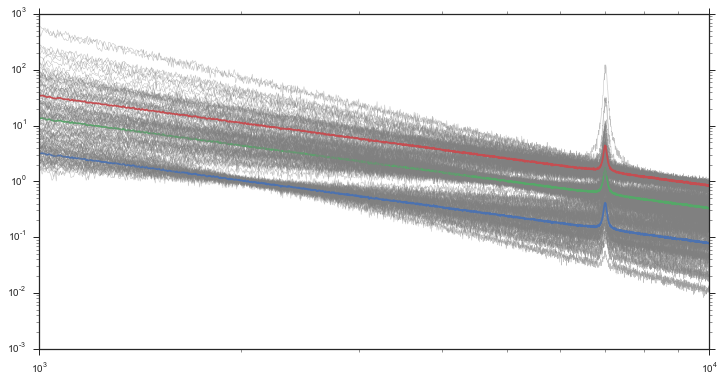

In [210]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
    
    mean = stat.gmean(y, axis = 0)
    ax.plot(t, mean)
    
plt.semilogx()
plt.semilogy()

[]

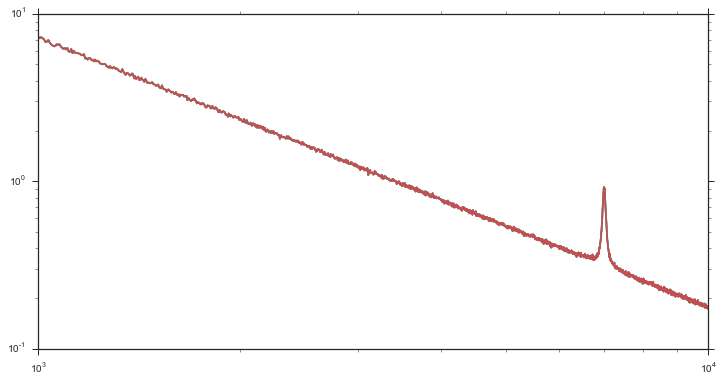

In [211]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = stat.gmean(y, axis = 0)
    ax.plot(t, mean / np.mean(mean))
    
plt.semilogx()
plt.semilogy()

For the weighted mean, we even see curvature. I think this is because we scale the errors with the value, thus giving higher error to larger values. 

[]

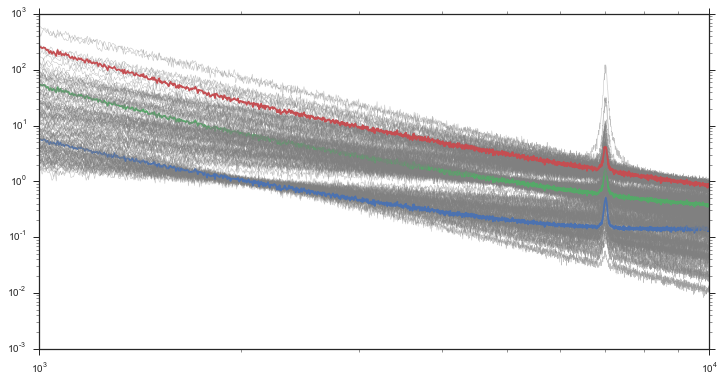

In [212]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
    
    mean = np.average(y, axis = 0, weights= yerr**2)
    ax.plot(t, mean)
    
plt.semilogx()
plt.semilogy()

[]

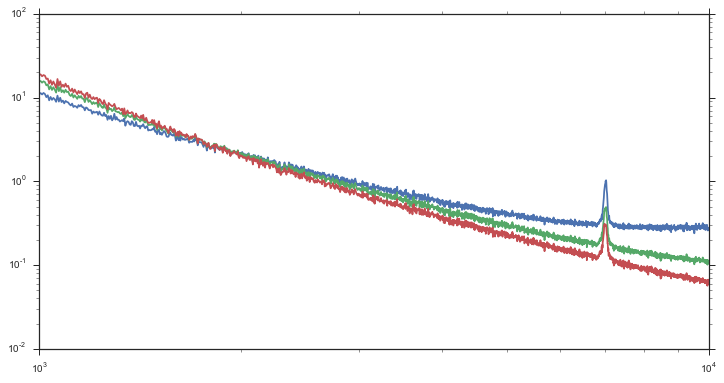

In [214]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)


for k in [2000, 5000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = np.average(y, axis = 0, weights= yerr**2)
    
    ax.plot(t, mean / np.mean(mean))
    
plt.semilogx()
plt.semilogy()
#plt.xlim((4000,6000))

###Broken power-law
Now what happens if we dont use a pure powerlaw, but instead a broken one? We generate new fake data and repeat the procedure.


In [129]:
from scipy.special import wofz

# Generating fake data
def linear(t, params):
    a, b = params
    return a * t + b

def parabola(t, params):
    a, b, c = params
    return a * t**2 + b * t + c

def power_law(t, params):
    A, lambda_0, alpha = params
    return A * (t / lambda_0) ** alpha 

def broken_power_law(t, params):
    A_1, lambda_0, alpha_0, alpha_1 = params
    val1 = power_law(t, [A_1, lambda_0, alpha_0])[t<lambda_0]
    scale2loc = np.argmin(np.abs(t - lambda_0))
    A_2 = power_law(t[scale2loc], [A_1, lambda_0, (alpha_0 - alpha_1)])
    val2 = power_law(t, [A_2, lambda_0, alpha_1])[t>= lambda_0]
    return np.concatenate((val1,val2))

def voigt(xarr, params):
    """
    voigt profile
    V(x,sig,gam) = Re(w(z))/(sig*sqrt(2*pi))
    z = (x+i*gam)/(sig*sqrt(2))

    Converted from
    http://mail.scipy.org/pipermail/scipy-user/2011-January/028327.html
    """
    amp,xcen,Gfwhm,Lfwhm = params
    tmp = 1.0/wofz(np.zeros((len(xarr)))+1j*np.sqrt(np.log(2.0))*Lfwhm).real
    tmp = tmp*amp*wofz(2*np.sqrt(np.log(2.0))*(xarr-xcen)/Gfwhm+1j*np.sqrt(np.log(2.0))*Lfwhm).real
    return tmp



def generate_data(params_pow, params_voigt, N):
    
    t = np.arange(1000, 10000, 5)
    y = np.zeros([N, len(t)])
    yerr = y.copy()
    print(N)
    for n in range(N):
        y[n] = broken_power_law(t, params_pow[n]) + voigt(t, params_voigt[n]) 
        yerr[n] = y[n] * 0.2
        y[n] += yerr[n] * np.random.randn(len(t))
    return t, y, yerr

n_sets = 50

mu_A, sigma_A = 1e10, 1e9 # mean and standard deviation
A = np.random.normal(mu_A, sigma_A, n_sets)

mu_lambda_0, sigma_lambda_0 = 3500, 1000 # mean and standard deviation
lambda_0 = np.random.normal(mu_lambda_0, sigma_lambda_0, n_sets)

mu_alpha_0, sigma_alpha_0 = -1.5, 0.5 # mean and standard deviation
alpha_0 = np.random.normal(mu_alpha_0, sigma_alpha_0, n_sets)

mu_alpha_1, sigma_alpha_1 = -3.0, 0.5 # mean and standard deviation
alpha_1 = np.random.normal(mu_alpha_1, sigma_alpha_1, n_sets)

parameters = np.array([A, lambda_0, alpha_0, alpha_1]).transpose()


mu_amp, sigma_amp = 1, 0.3 # mean and standard deviation
amp = np.random.normal(mu_amp, sigma_amp, n_sets)

mu_xcen, sigma_xcen = 5000, 10 # mean and standard deviation
xcen= np.random.normal(mu_xcen, sigma_xcen, n_sets)

mu_Gfwhm, sigma_Gfwhm = 50, 10 # mean and standard deviation
Gfwhm = np.random.normal(mu_Gfwhm, sigma_Gfwhm, n_sets)

mu_Lfwhm, sigma_Lfwhm = 1, 0.5 # mean and standard deviation
Lfwhm = np.random.normal(mu_Lfwhm, sigma_Lfwhm, n_sets)

parameters_v = np.array([amp * 2e5*np.sqrt(A),xcen,Gfwhm,Lfwhm]).transpose()




t, y, yerr = generate_data(parameters, parameters_v, n_sets)




50


[]

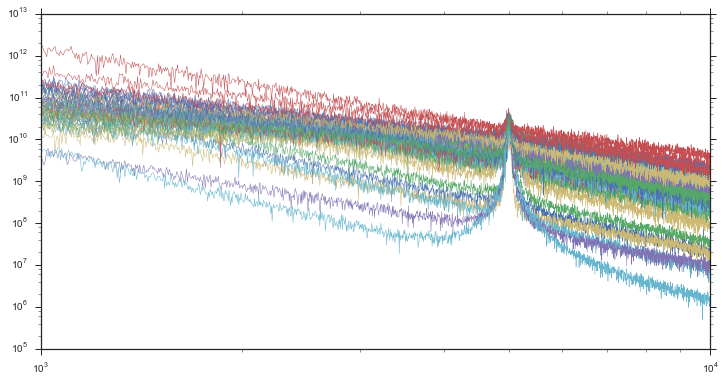

In [130]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)
for n in range(n_sets):
    ax.plot(t, y[n], lw=0.5)
plt.semilogx()
plt.semilogy()   

[]

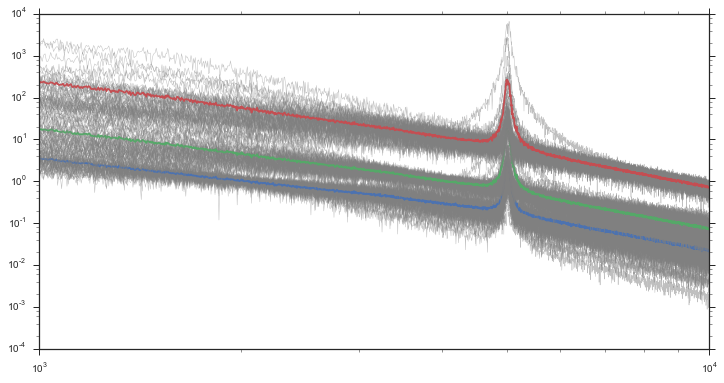

In [131]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 4000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
    
    mean = np.average(y, axis = 0)
    ax.plot(t, mean)
    
plt.semilogx()
plt.semilogy()

[]

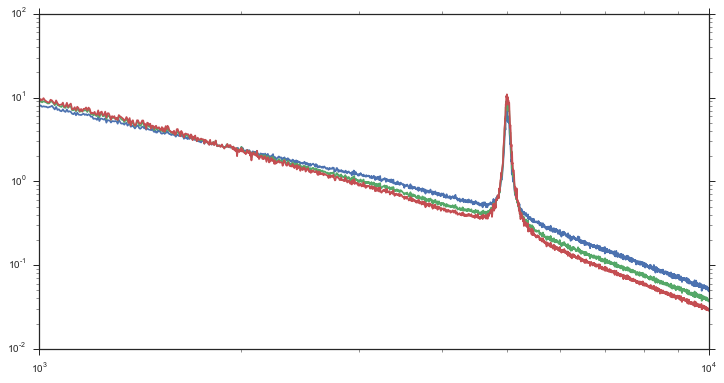

In [137]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 4000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = np.average(y, axis = 0)
    ax.plot(t, mean / np.mean(mean))
    
plt.semilogx()
plt.semilogy()
#plt.xlim((4000,6000))


[]

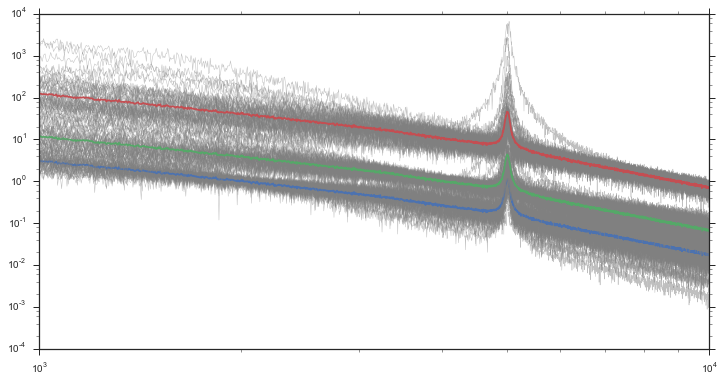

In [133]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 4000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
    
    mean = stat.gmean(y, axis = 0)
    ax.plot(t, mean)
    
plt.semilogx()
plt.semilogy()

[]

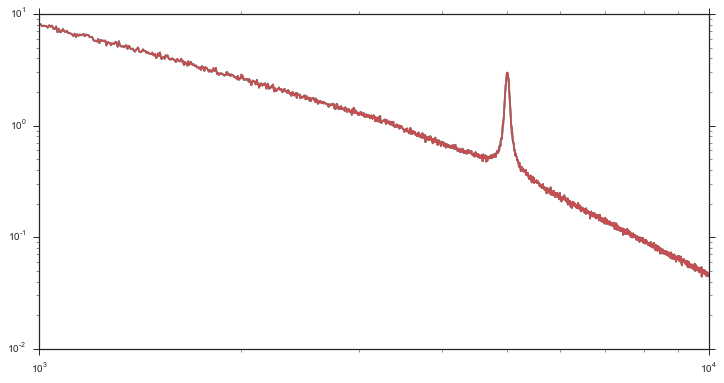

In [134]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 4000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = stat.gmean(y, axis = 0)
    ax.plot(t, mean / np.mean(mean))
    
plt.semilogx()
plt.semilogy()

[]

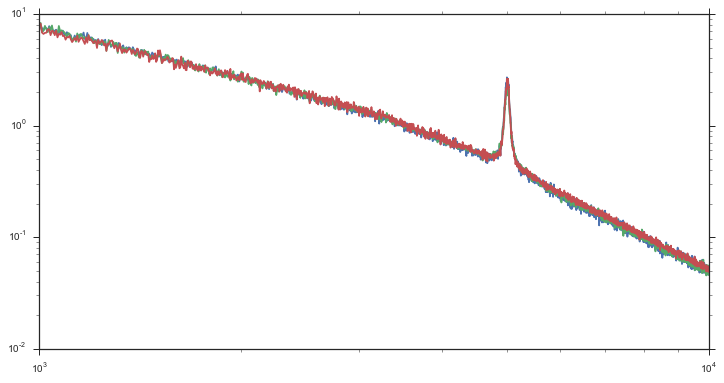

In [135]:
fig, ax = plt.subplots(1, figsize=(12,6), dpi=1000)

for k in [2000, 4000, 9000]:
    for n in range(n_sets):    
        mask = (t > k) & (t < k + 100)
        norm = np.mean(y[n][mask])
        y[n] /= norm
        #ax.plot(t, y[n], lw=0.5, color='grey', alpha = 0.5)
        
    mean = np.median(y, axis = 0)
    ax.plot(t, mean / np.mean(mean))
    
plt.semilogx()
plt.semilogy()